---
title: "Data Analysis"
subtitle: "Comprehensive Data Cleaning & Exploratory Analysis of Job Market Trends"
author:
  - name: Caroline O'Sullivan
    affiliations:
      - id: bu
        name: Boston University
        city: Boston
        state: MA
  - name: Bhargavi Manyala
    affiliations:
      - ref: bu
  - name: Taylor Luckenbill
    affiliations:
      - ref: bu      
bibliography: bibliography.bib
csl: csl/econometrica.csl
format: 
  html:
    toc: true
    number-sections: true
    df-print: paged
engine: jupyter
jupyter: python3
execute:
  echo: true      
  eval: true      
  output: true    
  freeze: auto 
---


# Import Data
Importing dataset using Pyspark..The code shows the schema and few rows of the dataset.


In [33]:
from pyspark.sql import SparkSession

# Start a Spark session
spark = SparkSession.builder.appName("JobPostingsAnalysis").getOrCreate()

    
# Load the CSV file into a Spark DataFrame
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .csv("lightcast_job_postings.csv")

df.createOrReplaceTempView("jobs")


# Show schema
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATION_LEVELS_NAME: string (nullable = true)
 |-- MIN_EDULEVELS: integer (

In [34]:
#| echo : false
df.show(5, truncate=False)


+----------------------------------------+-----------------+-----------------------+----------+--------+---------+--------+----------------------+---------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+-------------------+------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Data Cleaning & Preprocessing

## Drop Unnecessary Columns

### Redundant Columns

* Drop: NAICS2, NAICS2_NAME, NAICS3, NAICS3_NAME, NAICS4, NAICS4_NAME, NAICS5, NAICS5_NAME, NAICS6, NAICS6_NAME
* Retain: NAICS_2022_2, NAICS_2022_2_NAME through NAICS_2022_6, NAICS_2022_6_NAME
* Drop: SOC_2, SOC_2_NAME, SOC_3, SOC_3_NAME, SOC_4, SOC_4_NAME, SOC_5, SOC_5_NAME
* Retain: SOC_2021_2, SOC_2021_2_NAME, SOC_2021_3, SOC_2021_3_NAME, SOC_2021_4, SOC_2021_4_NAME, SOC_2021_5, SOC_2021_5_NAME
* Drop: CITY, COUNTY, STATE, REMOTE_TYPE, EMPLOYMENT_TYPE (numeric codes when text names exist)
* Drop : COUNTY_OUTGOING, COUNTY_NAME_OUTGOING, COUNTY_INCOMING, COUNTY_NAME_INCOMING, MSA_OUTGOING, MSA_NAME_OUTGOING, MSA_INCOMING, MSA_NAME_INCOMING (geographic mobility data)
* Retain: LOCATION, CITY_NAME, COUNTY_NAME, STATE_NAME, MSA, MSA_NAME, REMOTE_TYPE_NAME, EMPLOYMENT_TYPE_NAME (text-based fields)
* Drop: TITLE_RAW, TITLE, TITLE_NAME, COMPANY_RAW (unprocessed versions)
* Retain: TITLE_CLEAN, COMPANY_NAME (cleaned/processed versions)
* Drop: EDUCATION_LEVELS, MIN_EDULEVELS, MAX_EDULEVELS (numeric codes)
* Retain : EDUCATION_LEVELS_NAME, MIN_EDULEVELS_NAME, MAX_EDULEVELS_NAME (descriptive names)
* Drop: LOT_V6_SPECIALIZED_OCCUPATION, LOT_V6_SPECIALIZED_OCCUPATION_NAME, LOT_V6_OCCUPATION, LOT_V6_OCCUPATION_NAME,  LOT_V6_OCCUPATION_GROUP, LOT_V6_OCCUPATION_GROUP_NAME, LOT_V6_CAREER_AREA, LOT_V6_CAREER_AREA_NAME (version-specific)
* Retain: LOT_CAREER_AREA, LOT_CAREER_AREA_NAME, LOT_OCCUPATION, LOT_OCCUPATION_NAME, LOT_SPECIALIZED_OCCUPATION, LOT_SPECIALIZED_OCCUPATION_NAME, LOT_OCCUPATION_GROUP, LOT_OCCUPATION_GROUP_NAME (current standard)

### Irrelevant Columns

* Drop: LAST_UPDATED_DATE, LAST_UPDATED_TIMESTAMP, DUPLICATES, SOURCE_TYPES, SOURCES, ACTIVE_URLS, ACTIVE_SOURCES_INFO (system tracking only)
* Retain: Core job posting fields only
* Drop: ID, URL, BODY (technical identifier, link, and full text not needed for analysis)
* Retain: Main job details (title, company, salary, location)
* Drop: CIP6, CIP6_NAME, CIP4, CIP4_NAME, CIP2, CIP2_NAME (education codes)
  ONET, ONET_NAME, ONET_2019, ONET_2019_NAME (extra occupation codes)
  LIGHTCAST_SECTORS, LIGHTCAST_SECTORS_NAME, (alternative grouping)
* Retain: Standard NAICS, SOC, and LOT classifications only
* Drop: SKILLS, SKILLS_NAME, SPECIALIZED_SKILLS, SPECIALIZED_SKILLS_NAME, CERTIFICATIONS, CERTIFICATIONS_NAME, COMMON_SKILLS,      COMMON_SKILLS_NAME, SOFTWARE_SKILLS, SOFTWARE_SKILLS_NAME (too detailed text fields)
* Retain: Key job attributes only
* Drop: MODELED_EXPIRED, MODELED_DURATION (estimates, not real values)
* Retain: POSTED, EXPIRED, DURATION (actual posting data)

### Why are we removing multiple versions of NAICS/SOC codes?

The dataset includes both older and newer versions of industry (NAICS) and occupation (SOC) codes. Keeping multiple versions creates duplication and confusion because the same job could be categorized under two systems. To avoid this, we retain only the most recent standards — NAICS 2022 and SOC 2021 — which reflect the current labor market.

### How will this improve analysis?

* Improves analysis as follows:
* Ensures clarity by eliminating overlapping or outdated categories.
* Maintains consistency so all jobs follow the same classification.
* Improves efficiency by reducing extra columns that don’t add value.
* Increases accuracy since results are based on the most up-to-date classification systems.

### Dropping Unnecessary Columns(Python Implementation)

In [35]:
columns_to_drop = [
    "NAICS2", "NAICS2_NAME", "NAICS3", "NAICS3_NAME",
    "NAICS4", "NAICS4_NAME", "NAICS5", "NAICS5_NAME",
    "NAICS6", "NAICS6_NAME","ID","URL","BODY",
    "SOC_2", "SOC_2_NAME", "SOC_3", "SOC_3_NAME",
    "SOC_4", "SOC_4_NAME", "SOC_5", "SOC_5_NAME",
    "CITY", "COUNTY", "STATE", "REMOTE_TYPE", "EMPLOYMENT_TYPE",
    "COUNTY_OUTGOING", "COUNTY_NAME_OUTGOING",
    "COUNTY_INCOMING", "COUNTY_NAME_INCOMING",
    "MSA_OUTGOING", "MSA_NAME_OUTGOING",
    "MSA_INCOMING", "MSA_NAME_INCOMING",
    "TITLE_RAW", "TITLE", "TITLE_NAME", "COMPANY_RAW",
    "EDUCATION_LEVELS", "MIN_EDULEVELS", "MAX_EDULEVELS",
    "LOT_V6_SPECIALIZED_OCCUPATION", "LOT_V6_SPECIALIZED_OCCUPATION_NAME",
    "LOT_V6_OCCUPATION", "LOT_V6_OCCUPATION_NAME",
    "LOT_V6_OCCUPATION_GROUP", "LOT_V6_OCCUPATION_GROUP_NAME",
    "LOT_V6_CAREER_AREA", "LOT_V6_CAREER_AREA_NAME",
    "LAST_UPDATED_DATE", "LAST_UPDATED_TIMESTAMP",
    "DUPLICATES", "SOURCE_TYPES", "SOURCES",
    "ACTIVE_URLS", "ACTIVE_SOURCES_INFO",
    "CIP2", "CIP2_NAME", "CIP4", "CIP4_NAME", "CIP6", "CIP6_NAME",
    "ONET", "ONET_NAME", "ONET_2019", "ONET_2019_NAME",
    "LIGHTCAST_SECTORS", "LIGHTCAST_SECTORS_NAME",
    "SKILLS", "SKILLS_NAME", "SPECIALIZED_SKILLS", "SPECIALIZED_SKILLS_NAME",
    "CERTIFICATIONS", "CERTIFICATIONS_NAME",
    "COMMON_SKILLS", "COMMON_SKILLS_NAME",
    "SOFTWARE_SKILLS", "SOFTWARE_SKILLS_NAME",
    "MODELED_EXPIRED", "MODELED_DURATION"
]

df = df.drop(*columns_to_drop)
df.show(truncate=False)
df.count()


+--------+---------+--------+---------+-----------------------------------+-------------------+---------------------------------------------------------------------------+-------------------+------------------+----------------------+--------------------+--------------------+-------------+------+----------------+-------------------+---------+-----------+-------------------------------------------------+------------------+--------------------+-----+-------------------------------------+-------------+-------------------------------------------------------------------------+----------+-------------------------------------+----------+--------------------------------+----------+---------------+----------+---------------+---------------+-------------------------------------------+--------------+-------------------------------------+--------------------------+--------------------------------+--------------------+-------------------------------+------------+-------------------------------------

72498

## Handling Missing Values(Numerical Python Implementation)

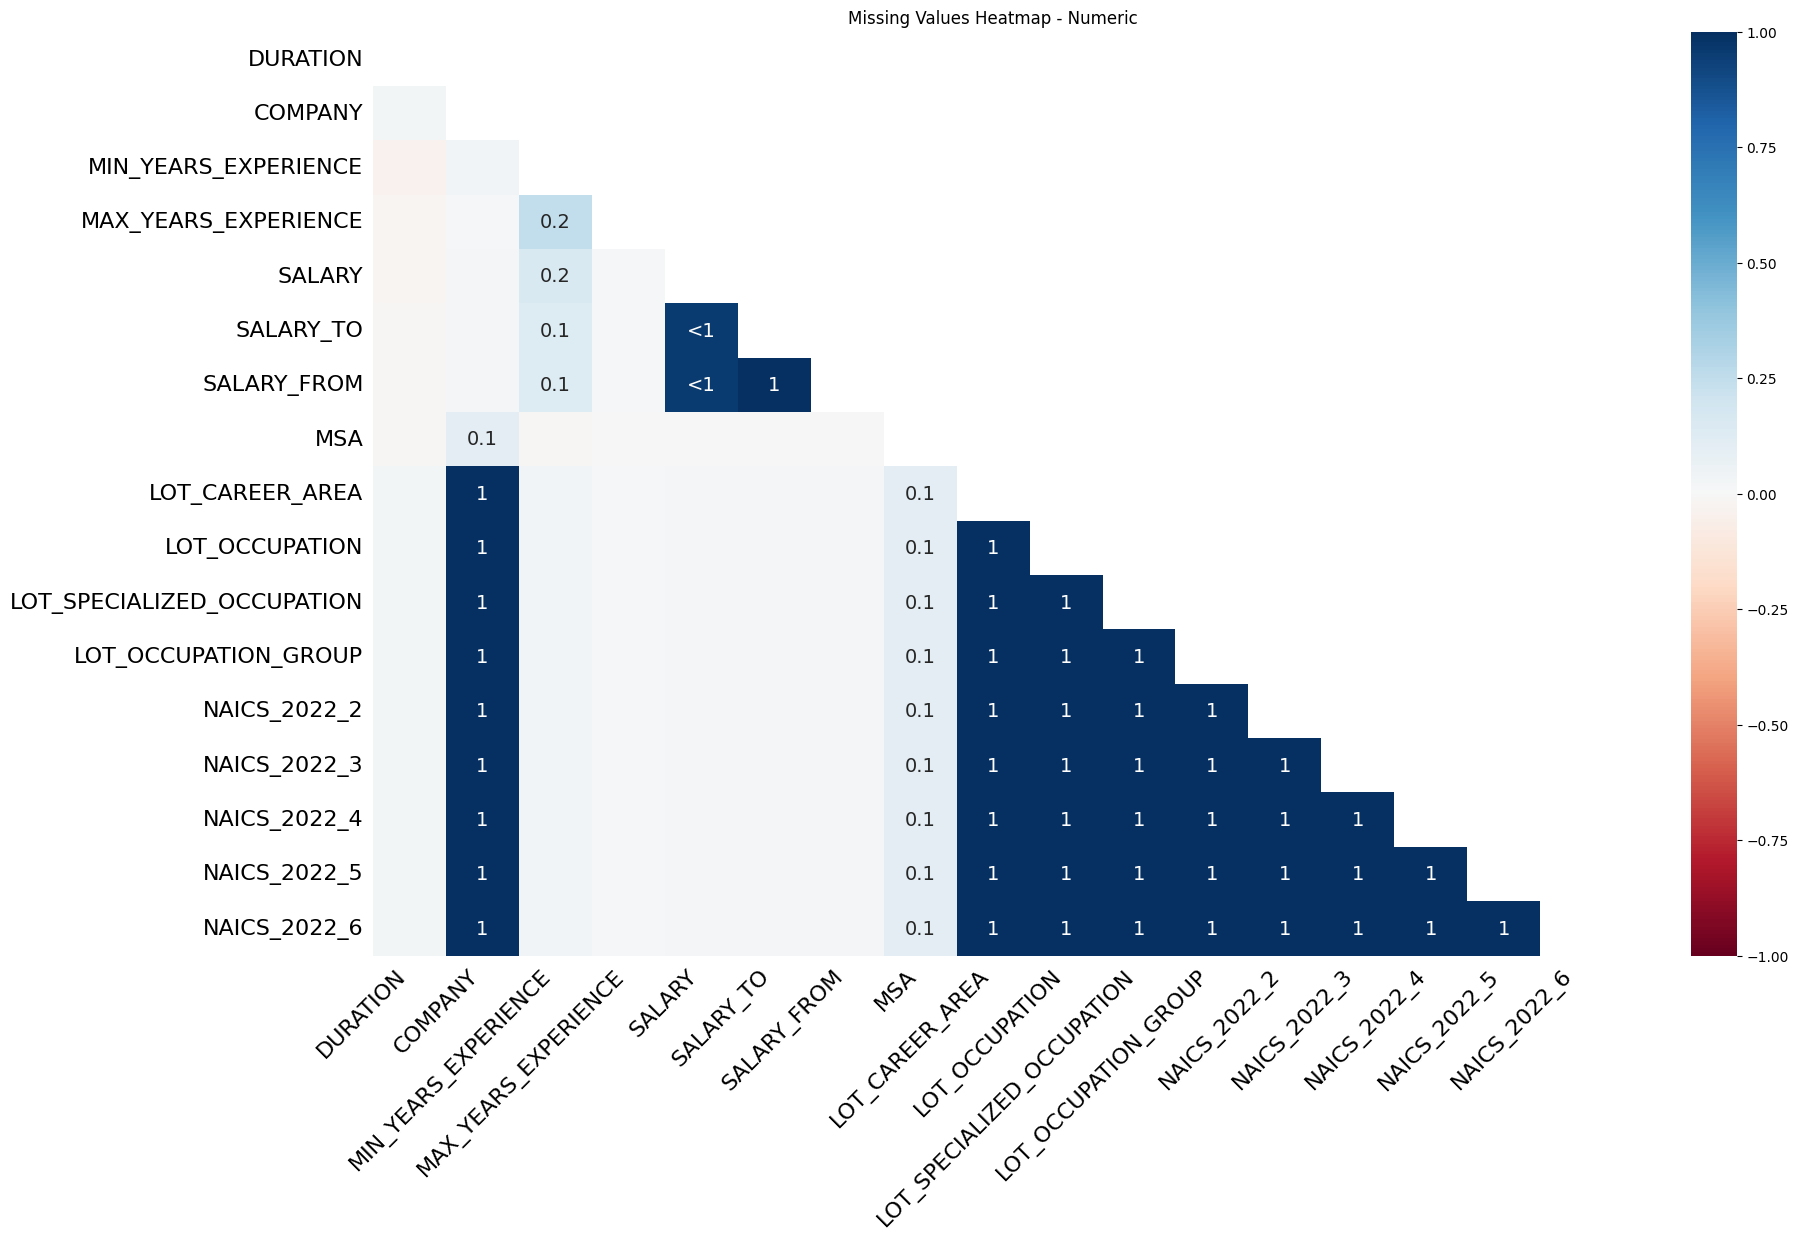

,DURATION,COMPANY,MIN_YEARS_EXPERIENCE,MAX_YEARS_EXPERIENCE,SALARY,SALARY_TO,SALARY_FROM,MSA,LOT_CAREER_AREA,LOT_OCCUPATION,LOT_SPECIALIZED_OCCUPATION,LOT_OCCUPATION_GROUP,NAICS_2022_2,NAICS_2022_3,NAICS_2022_4,NAICS_2022_5,NAICS_2022_6
0,6.0,894731.0,2.0,2.0,116300.0,131040.0,88000.0,20980.0,23.0,231010.0,23101011.0,2310.0,44.0,441.0,4413.0,44133.0,441330.0
1,18.0,133098.0,3.0,3.0,116300.0,131040.0,88000.0,12300.0,23.0,231010.0,23101012.0,2310.0,56.0,561.0,5613.0,56132.0,561320.0
2,35.0,39063746.0,5.0,3.0,116300.0,131040.0,88000.0,19100.0,23.0,231113.0,23111310.0,2311.0,52.0,524.0,5242.0,52429.0,524291.0
3,48.0,37615159.0,3.0,3.0,116300.0,131040.0,88000.0,38060.0,23.0,231113.0,23111310.0,2311.0,52.0,522.0,5221.0,52211.0,522110.0
4,15.0,0.0,5.0,3.0,92500.0,150000.0,35000.0,33700.0,23.0,231010.0,23101012.0,2310.0,99.0,999.0,9999.0,99999.0,999999.0


In [36]:
import missingno as msno
import matplotlib.pyplot as plt

numeric_cols = [
    "DURATION", "COMPANY", "MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE",
    "SALARY", "SALARY_TO", "SALARY_FROM", "MSA",
    "LOT_CAREER_AREA", "LOT_OCCUPATION", "LOT_SPECIALIZED_OCCUPATION",
    "LOT_OCCUPATION_GROUP", "NAICS_2022_2", "NAICS_2022_3",
    "NAICS_2022_4", "NAICS_2022_5", "NAICS_2022_6"
]

pandas_num = df.select(numeric_cols).toPandas()

msno.heatmap(pandas_num)
plt.title("Missing Values Heatmap - Numeric")
plt.show()

pandas_num[numeric_cols] = pandas_num[numeric_cols].fillna(
    pandas_num[numeric_cols].median(numeric_only=True)
)
pandas_num.head()

## Handling Missing Values(Categorical Python Implementation)

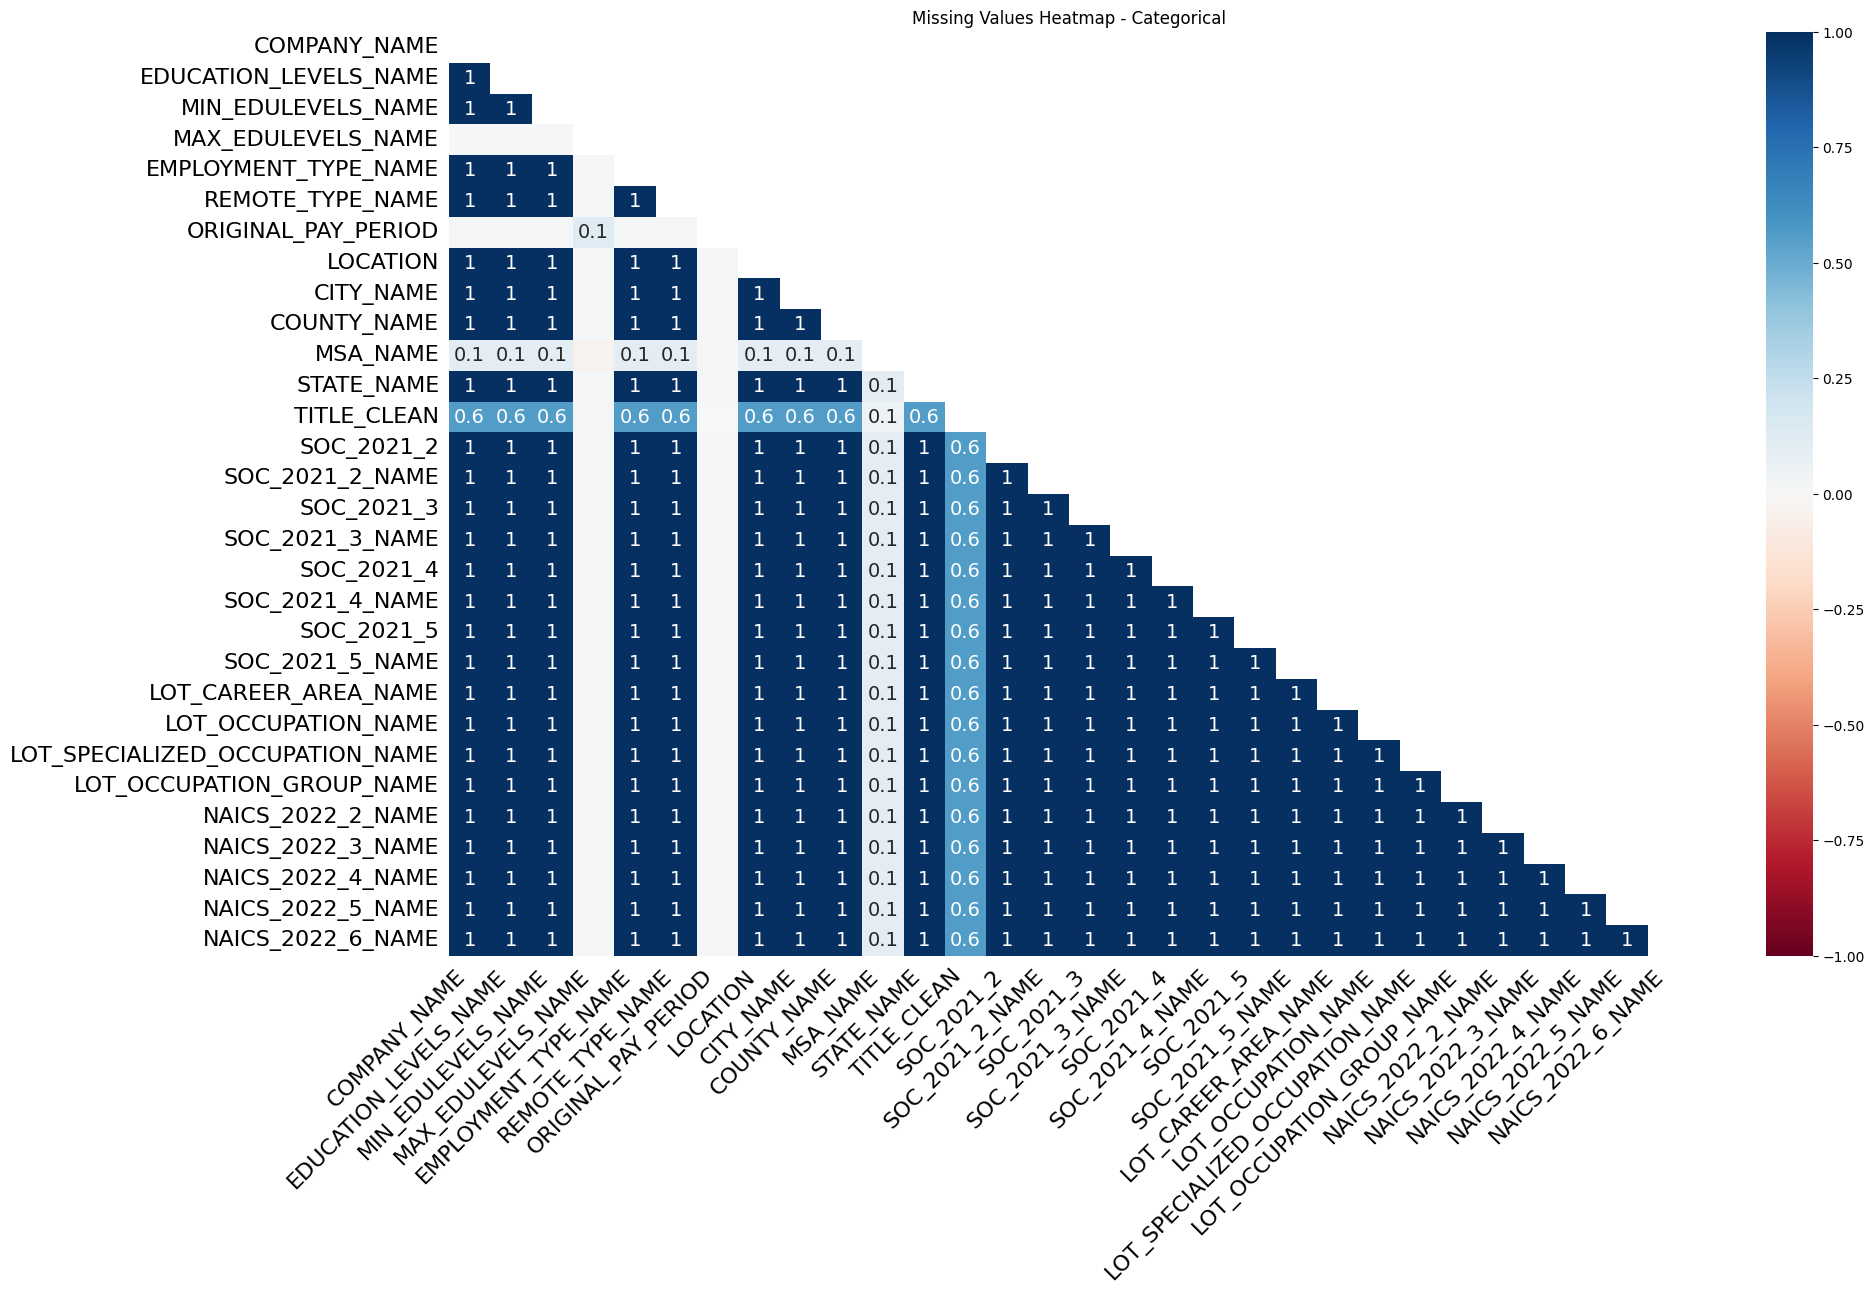

,COMPANY_NAME,EDUCATION_LEVELS_NAME,MIN_EDULEVELS_NAME,MAX_EDULEVELS_NAME,EMPLOYMENT_TYPE_NAME,REMOTE_TYPE_NAME,ORIGINAL_PAY_PERIOD,LOCATION,CITY_NAME,COUNTY_NAME,...,SOC_2021_5_NAME,LOT_CAREER_AREA_NAME,LOT_OCCUPATION_NAME,LOT_SPECIALIZED_OCCUPATION_NAME,LOT_OCCUPATION_GROUP_NAME,NAICS_2022_2_NAME,NAICS_2022_3_NAME,NAICS_2022_4_NAME,NAICS_2022_5_NAME,NAICS_2022_6_NAME
0,Murphy USA,"[\n ""Bachelor's degree""\n]",Bachelor's degree,Unknown,Full-time (> 32 hours),[None],Unknown,"{\n ""lat"": 33.20763,\n ""lon"": -92.6662674\n}","El Dorado, AR","Union, AR",...,Data Scientists,Information Technology and Computer Science,Business Intelligence Analyst,General ERP Analyst / Consultant,Business Intelligence,Retail Trade,Motor Vehicle and Parts Dealers,"Automotive Parts, Accessories, and Tire Retailers",Automotive Parts and Accessories Retailers,Automotive Parts and Accessories Retailers
1,Smx Corporation Limited,"[\n ""No Education Listed""\n]",No Education Listed,Unknown,Full-time (> 32 hours),Remote,Unknown,"{\n ""lat"": 44.3106241,\n ""lon"": -69.7794897\n}","Augusta, ME","Kennebec, ME",...,Data Scientists,Information Technology and Computer Science,Business Intelligence Analyst,Oracle Consultant / Analyst,Business Intelligence,Administrative and Support and Waste Managemen...,Administrative and Support Services,Employment Services,Temporary Help Services,Temporary Help Services
2,Sedgwick,"[\n ""Bachelor's degree""\n]",Bachelor's degree,Unknown,Full-time (> 32 hours),[None],Unknown,"{\n ""lat"": 32.7766642,\n ""lon"": -96.7969879\n}","Dallas, TX","Dallas, TX",...,Data Scientists,Information Technology and Computer Science,Data / Data Mining Analyst,Data Analyst,Data Analysis and Mathematics,Finance and Insurance,Insurance Carriers and Related Activities,"Agencies, Brokerages, and Other Insurance Rela...",Other Insurance Related Activities,Claims Adjusting
3,Wells Fargo,"[\n ""No Education Listed""\n]",No Education Listed,Unknown,Full-time (> 32 hours),[None],Unknown,"{\n ""lat"": 33.4483771,\n ""lon"": -112.0740373\n}","Phoenix, AZ","Maricopa, AZ",...,Data Scientists,Information Technology and Computer Science,Data / Data Mining Analyst,Data Analyst,Data Analysis and Mathematics,Finance and Insurance,Credit Intermediation and Related Activities,Depository Credit Intermediation,Commercial Banking,Commercial Banking
4,Unclassified,"[\n ""No Education Listed""\n]",No Education Listed,Unknown,Part-time / full-time,[None],year,"{\n ""lat"": 37.6392595,\n ""lon"": -120.9970014\n}","Modesto, CA","Stanislaus, CA",...,Data Scientists,Information Technology and Computer Science,Business Intelligence Analyst,Oracle Consultant / Analyst,Business Intelligence,Unclassified Industry,Unclassified Industry,Unclassified Industry,Unclassified Industry,Unclassified Industry


In [37]:
import missingno as msno
import matplotlib.pyplot as plt

categorical_cols = [
    "COMPANY_NAME", "EDUCATION_LEVELS_NAME",
    "MIN_EDULEVELS_NAME", "MAX_EDULEVELS_NAME", "EMPLOYMENT_TYPE_NAME",
    "REMOTE_TYPE_NAME", "ORIGINAL_PAY_PERIOD", "LOCATION", "CITY_NAME",
    "COUNTY_NAME", "MSA_NAME", "STATE_NAME", "TITLE_CLEAN",
    "SOC_2021_2", "SOC_2021_2_NAME", "SOC_2021_3", "SOC_2021_3_NAME",
    "SOC_2021_4", "SOC_2021_4_NAME", "SOC_2021_5", "SOC_2021_5_NAME",
    "LOT_CAREER_AREA_NAME", "LOT_OCCUPATION_NAME",
    "LOT_SPECIALIZED_OCCUPATION_NAME", "LOT_OCCUPATION_GROUP_NAME",
    "NAICS_2022_2_NAME", "NAICS_2022_3_NAME", "NAICS_2022_4_NAME",
    "NAICS_2022_5_NAME", "NAICS_2022_6_NAME"
]

pandas_cat = df.select(categorical_cols).toPandas()

msno.heatmap(pandas_cat)
plt.title("Missing Values Heatmap - Categorical")
plt.show()

pandas_cat[categorical_cols] = pandas_cat[categorical_cols].fillna("Unknown")

pandas_cat.head()

## Handling Missing Values(Date Python Implementation)

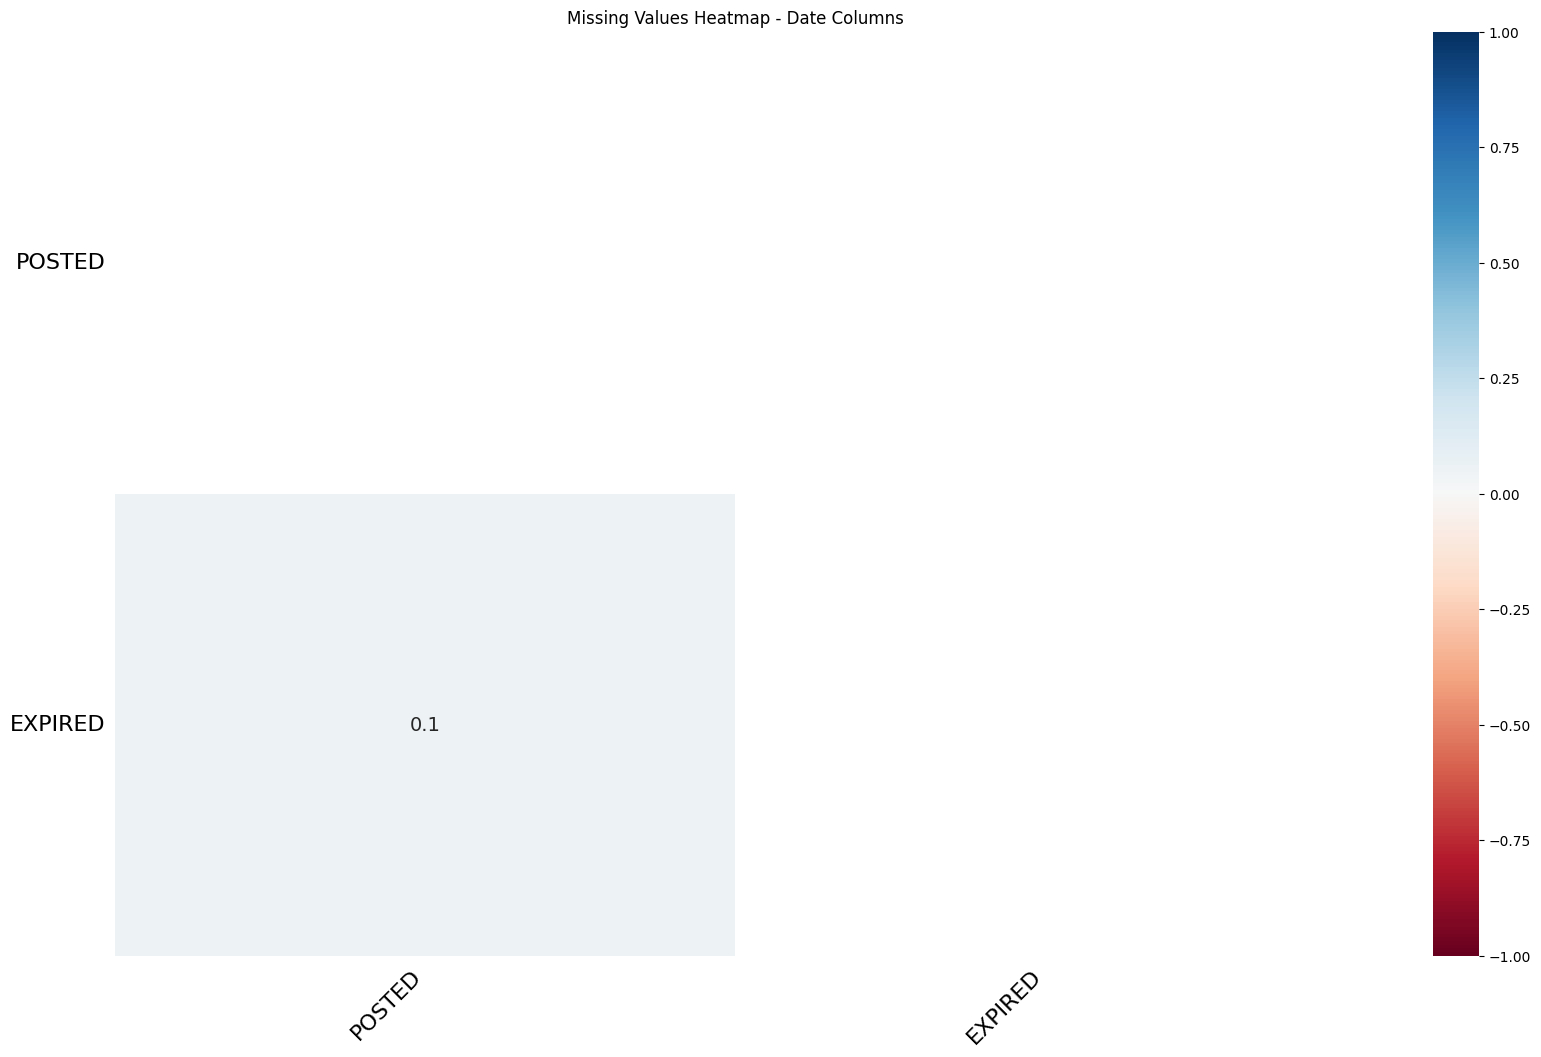

,POSTED,EXPIRED
0,2024-06-02,2024-06-08
1,2024-06-02,2024-08-01
2,2024-06-02,2024-07-07
3,2024-06-02,2024-07-20
4,2024-06-02,2024-06-17


In [38]:
import missingno as msno
import matplotlib.pyplot as plt
import pandas as pd

date_cols = ["POSTED", "EXPIRED"]
pandas_date = df.select(date_cols).toPandas()

msno.heatmap(pandas_date)
plt.title("Missing Values Heatmap - Date Columns")
plt.show()

for col in date_cols:
    pandas_date[col] = pd.to_datetime(pandas_date[col], errors="coerce")
    pandas_date[col] = pandas_date[col].fillna(pandas_date[col].mode()[0])

pandas_date.head()

## Handling Missing Values(Combined Dataframe Python Implementation)

In [39]:
import pandas as pd

pandas_handled_missing_values = pd.concat([pandas_num, pandas_cat, pandas_date], axis=1)

pandas_handled_missing_values.head()

,DURATION,COMPANY,MIN_YEARS_EXPERIENCE,MAX_YEARS_EXPERIENCE,SALARY,SALARY_TO,SALARY_FROM,MSA,LOT_CAREER_AREA,LOT_OCCUPATION,...,LOT_OCCUPATION_NAME,LOT_SPECIALIZED_OCCUPATION_NAME,LOT_OCCUPATION_GROUP_NAME,NAICS_2022_2_NAME,NAICS_2022_3_NAME,NAICS_2022_4_NAME,NAICS_2022_5_NAME,NAICS_2022_6_NAME,POSTED,EXPIRED
0,6.0,894731.0,2.0,2.0,116300.0,131040.0,88000.0,20980.0,23.0,231010.0,...,Business Intelligence Analyst,General ERP Analyst / Consultant,Business Intelligence,Retail Trade,Motor Vehicle and Parts Dealers,"Automotive Parts, Accessories, and Tire Retailers",Automotive Parts and Accessories Retailers,Automotive Parts and Accessories Retailers,2024-06-02,2024-06-08
1,18.0,133098.0,3.0,3.0,116300.0,131040.0,88000.0,12300.0,23.0,231010.0,...,Business Intelligence Analyst,Oracle Consultant / Analyst,Business Intelligence,Administrative and Support and Waste Managemen...,Administrative and Support Services,Employment Services,Temporary Help Services,Temporary Help Services,2024-06-02,2024-08-01
2,35.0,39063746.0,5.0,3.0,116300.0,131040.0,88000.0,19100.0,23.0,231113.0,...,Data / Data Mining Analyst,Data Analyst,Data Analysis and Mathematics,Finance and Insurance,Insurance Carriers and Related Activities,"Agencies, Brokerages, and Other Insurance Rela...",Other Insurance Related Activities,Claims Adjusting,2024-06-02,2024-07-07
3,48.0,37615159.0,3.0,3.0,116300.0,131040.0,88000.0,38060.0,23.0,231113.0,...,Data / Data Mining Analyst,Data Analyst,Data Analysis and Mathematics,Finance and Insurance,Credit Intermediation and Related Activities,Depository Credit Intermediation,Commercial Banking,Commercial Banking,2024-06-02,2024-07-20
4,15.0,0.0,5.0,3.0,92500.0,150000.0,35000.0,33700.0,23.0,231010.0,...,Business Intelligence Analyst,Oracle Consultant / Analyst,Business Intelligence,Unclassified Industry,Unclassified Industry,Unclassified Industry,Unclassified Industry,Unclassified Industry,2024-06-02,2024-06-17


##  Duplicates Removal(Python Implementation)

In [40]:
pandas_cleaned = pandas_handled_missing_values.drop_duplicates(
    subset=["TITLE_CLEAN", "COMPANY_NAME", "LOCATION","POSTED"],
    keep="first"
)

pandas_cleaned


,DURATION,COMPANY,MIN_YEARS_EXPERIENCE,MAX_YEARS_EXPERIENCE,SALARY,SALARY_TO,SALARY_FROM,MSA,LOT_CAREER_AREA,LOT_OCCUPATION,...,LOT_OCCUPATION_NAME,LOT_SPECIALIZED_OCCUPATION_NAME,LOT_OCCUPATION_GROUP_NAME,NAICS_2022_2_NAME,NAICS_2022_3_NAME,NAICS_2022_4_NAME,NAICS_2022_5_NAME,NAICS_2022_6_NAME,POSTED,EXPIRED
0,6.0,894731.0,2.0,2.0,116300.0,131040.0,88000.0,20980.0,23.0,231010.0,...,Business Intelligence Analyst,General ERP Analyst / Consultant,Business Intelligence,Retail Trade,Motor Vehicle and Parts Dealers,"Automotive Parts, Accessories, and Tire Retailers",Automotive Parts and Accessories Retailers,Automotive Parts and Accessories Retailers,2024-06-02,2024-06-08
1,18.0,133098.0,3.0,3.0,116300.0,131040.0,88000.0,12300.0,23.0,231010.0,...,Business Intelligence Analyst,Oracle Consultant / Analyst,Business Intelligence,Administrative and Support and Waste Managemen...,Administrative and Support Services,Employment Services,Temporary Help Services,Temporary Help Services,2024-06-02,2024-08-01
2,35.0,39063746.0,5.0,3.0,116300.0,131040.0,88000.0,19100.0,23.0,231113.0,...,Data / Data Mining Analyst,Data Analyst,Data Analysis and Mathematics,Finance and Insurance,Insurance Carriers and Related Activities,"Agencies, Brokerages, and Other Insurance Rela...",Other Insurance Related Activities,Claims Adjusting,2024-06-02,2024-07-07
3,48.0,37615159.0,3.0,3.0,116300.0,131040.0,88000.0,38060.0,23.0,231113.0,...,Data / Data Mining Analyst,Data Analyst,Data Analysis and Mathematics,Finance and Insurance,Credit Intermediation and Related Activities,Depository Credit Intermediation,Commercial Banking,Commercial Banking,2024-06-02,2024-07-20
4,15.0,0.0,5.0,3.0,92500.0,150000.0,35000.0,33700.0,23.0,231010.0,...,Business Intelligence Analyst,Oracle Consultant / Analyst,Business Intelligence,Unclassified Industry,Unclassified Industry,Unclassified Industry,Unclassified Industry,Unclassified Industry,2024-06-02,2024-06-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72493,15.0,37110815.0,3.0,3.0,116300.0,131040.0,88000.0,40060.0,23.0,231113.0,...,Data / Data Mining Analyst,Data Analyst,Data Analysis and Mathematics,"Professional, Scientific, and Technical Services","Professional, Scientific, and Technical Services",Computer Systems Design and Related Services,Computer Systems Design and Related Services,Custom Computer Programming Services,2024-08-16,2024-08-31
72494,18.0,59335641.0,10.0,3.0,169275.0,197550.0,141000.0,14460.0,23.0,231510.0,...,Computer Systems Engineer / Architect,Enterprise Architect,Network and Systems Engineering,Information,Publishing Industries,"Newspaper, Periodical, Book, and Directory Pub...",Book Publishers,Book Publishers,2024-08-16,2024-09-17
72495,37.0,36997534.0,5.0,3.0,72800.0,83200.0,62400.0,29620.0,23.0,231113.0,...,Data / Data Mining Analyst,Data Analyst,Data Analysis and Mathematics,Administrative and Support and Waste Managemen...,Administrative and Support Services,Employment Services,Employment Placement Agencies and Executive Se...,Employment Placement Agencies,2024-08-16,2024-09-22
72496,18.0,98412363.0,7.0,3.0,116300.0,131040.0,88000.0,12620.0,23.0,231113.0,...,Data / Data Mining Analyst,Data Analyst,Data Analysis and Mathematics,Information,Telecommunications,All Other Telecommunications,All Other Telecommunications,All Other Telecommunications,2024-08-16,2024-10-15


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_2718/706560984.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




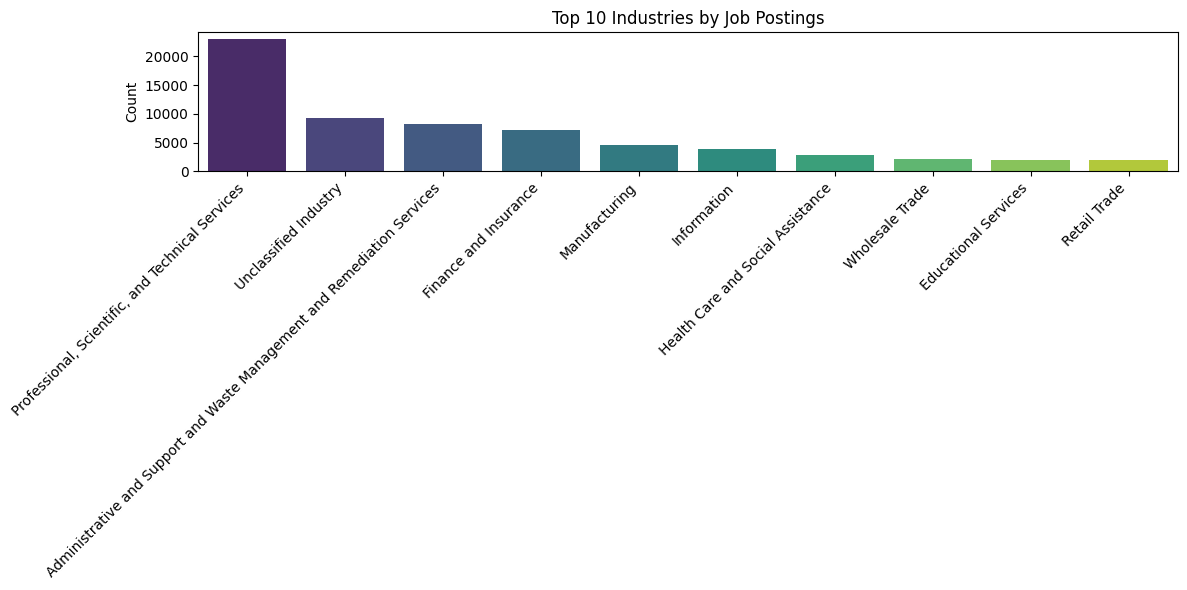

In [42]:
# Count occurrences
industry_counts = pandas_cleaned["NAICS_2022_2_NAME"].value_counts().reset_index()
industry_counts.columns = ["Industry", "Count"]

# Optional: limit to top 10 for readability
top10 = industry_counts.head(10)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(
    data=top10,
    x="Industry",
    y="Count",
    palette="viridis"  # or "magma", "coolwarm", etc.
)

plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Industries by Job Postings")
plt.xlabel(None)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [43]:
# Restrict to top 10 industries
top10 = pandas_cleaned["NAICS_2022_2_NAME"].value_counts().index[:10]
filtered = pandas_cleaned[pandas_cleaned["NAICS_2022_2_NAME"].isin(top10)]

print(filtered.columns)

Index(['DURATION', 'COMPANY', 'MIN_YEARS_EXPERIENCE', 'MAX_YEARS_EXPERIENCE',
       'SALARY', 'SALARY_TO', 'SALARY_FROM', 'MSA', 'LOT_CAREER_AREA',
       'LOT_OCCUPATION', 'LOT_SPECIALIZED_OCCUPATION', 'LOT_OCCUPATION_GROUP',
       'NAICS_2022_2', 'NAICS_2022_3', 'NAICS_2022_4', 'NAICS_2022_5',
       'NAICS_2022_6', 'COMPANY_NAME', 'EDUCATION_LEVELS_NAME',
       'MIN_EDULEVELS_NAME', 'MAX_EDULEVELS_NAME', 'EMPLOYMENT_TYPE_NAME',
       'REMOTE_TYPE_NAME', 'ORIGINAL_PAY_PERIOD', 'LOCATION', 'CITY_NAME',
       'COUNTY_NAME', 'MSA_NAME', 'STATE_NAME', 'TITLE_CLEAN', 'SOC_2021_2',
       'SOC_2021_2_NAME', 'SOC_2021_3', 'SOC_2021_3_NAME', 'SOC_2021_4',
       'SOC_2021_4_NAME', 'SOC_2021_5', 'SOC_2021_5_NAME',
       'LOT_CAREER_AREA_NAME', 'LOT_OCCUPATION_NAME',
       'LOT_SPECIALIZED_OCCUPATION_NAME', 'LOT_OCCUPATION_GROUP_NAME',
       'NAICS_2022_2_NAME', 'NAICS_2022_3_NAME', 'NAICS_2022_4_NAME',
       'NAICS_2022_5_NAME', 'NAICS_2022_6_NAME', 'POSTED', 'EXPIRED'],
      dtype=

/tmp/ipykernel_2718/671861133.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




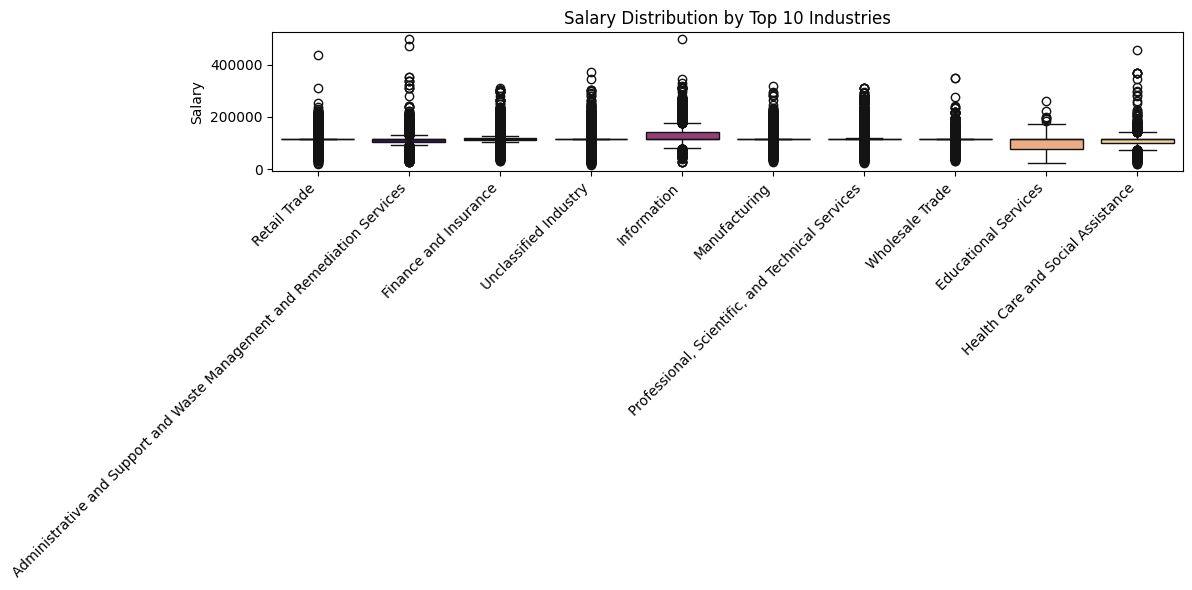

In [44]:
# Plot
plt.figure(figsize=(12,6))
sns.boxplot(
    data=filtered,
    x="NAICS_2022_2_NAME",
    y="SALARY",
    palette="magma"
)

plt.xticks(rotation=45, ha="right")
plt.title("Salary Distribution by Top 10 Industries")
plt.xlabel(None)
plt.ylabel("Salary")  
plt.tight_layout()
plt.show()




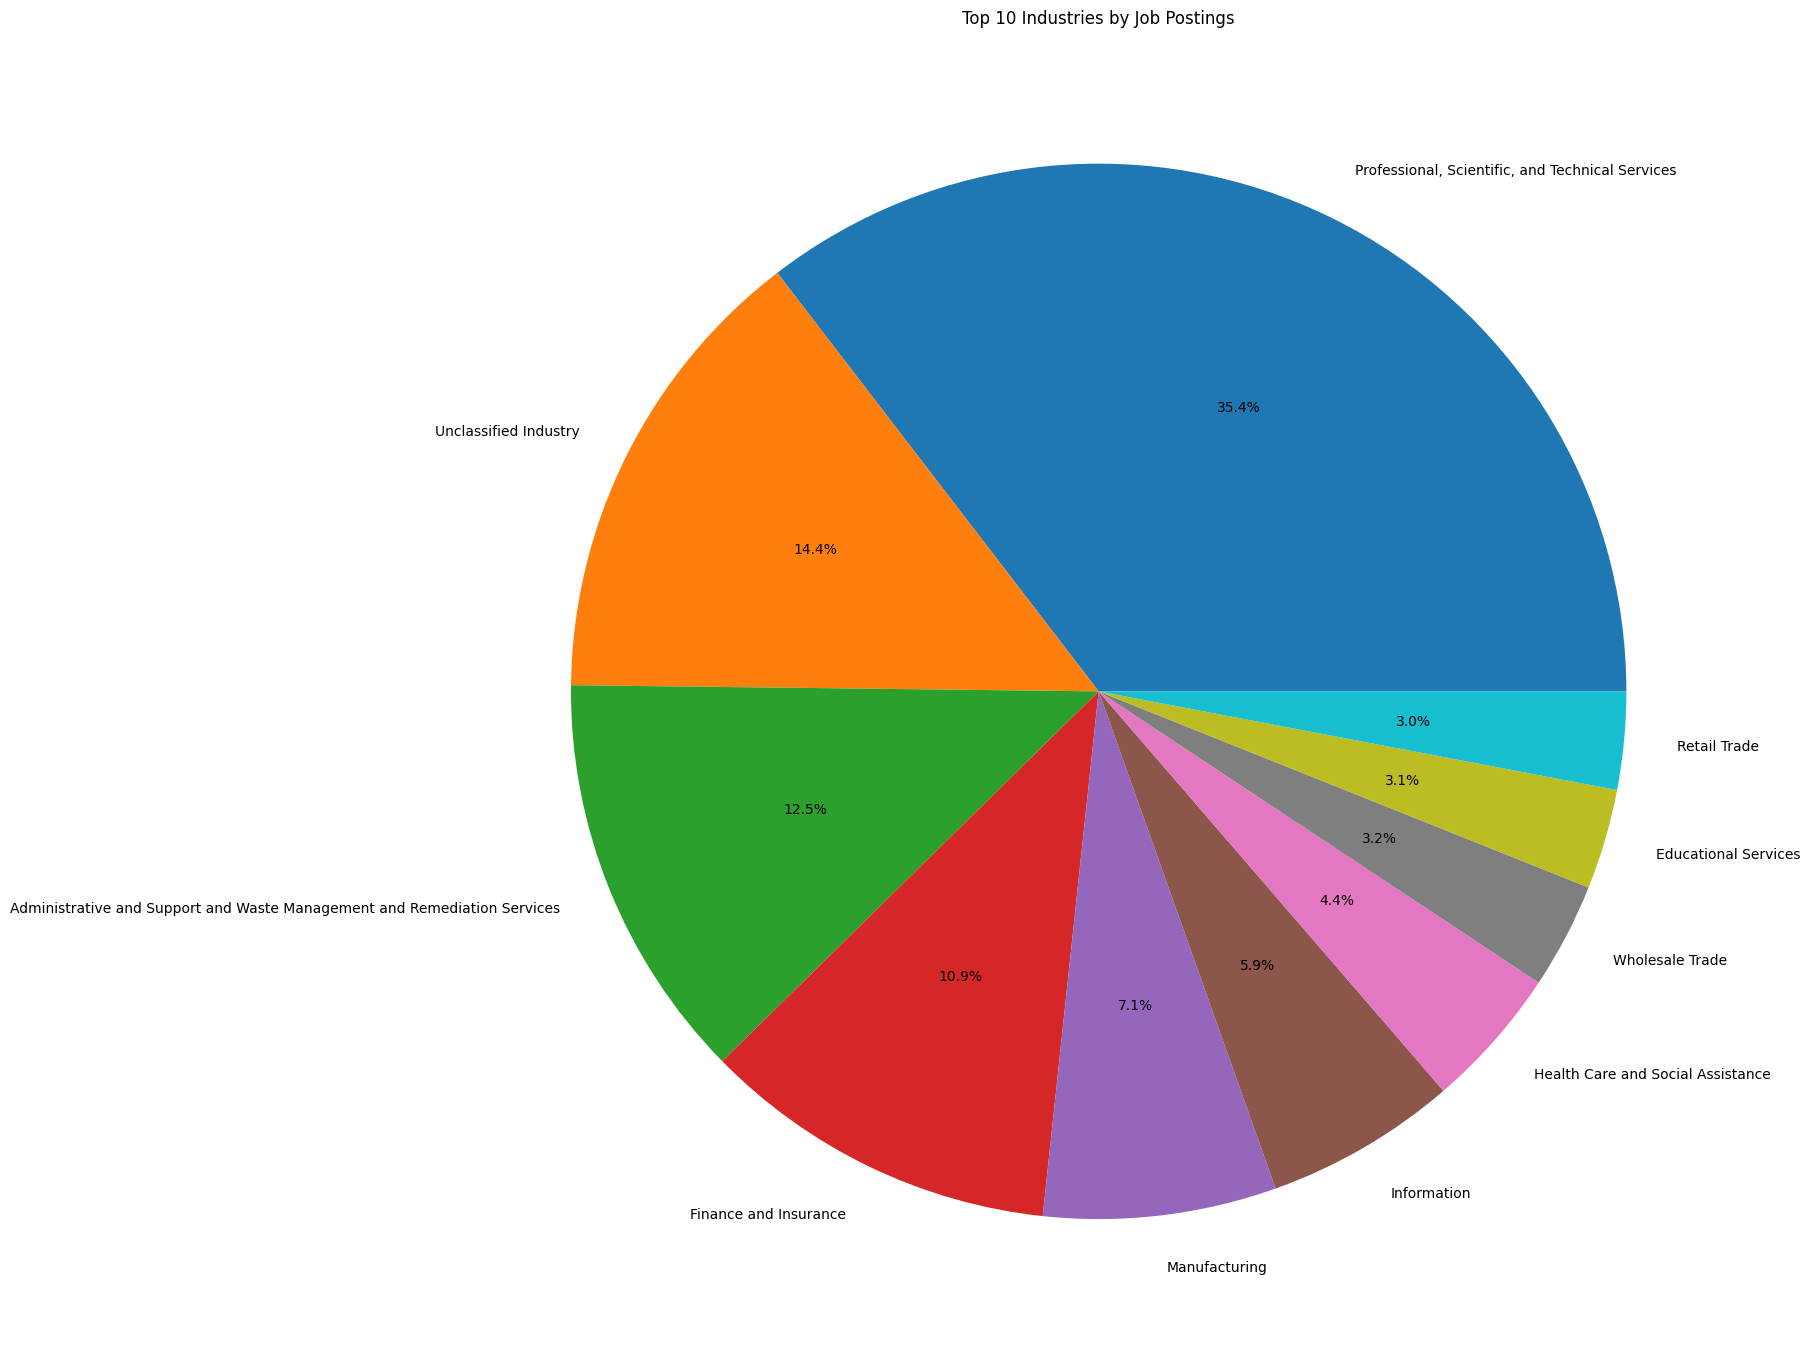

In [49]:
# Count occurrences
industry_counts = pandas_cleaned["NAICS_2022_2_NAME"].value_counts()

# take top 10 industries for readability
top10 = industry_counts.head(10)

# Pie chart
plt.figure(figsize=(18,18))
plt.pie(
    top10.values,           # sizes
    labels=top10.index,     # labels
    autopct='%1.1f%%',      # show percentages
)
plt.title("Top 10 Industries by Job Postings")
plt.tight_layout()
plt.show()
